In [9]:
import os
import yaml
import numpy as np

!pwd

def print_result(algo, target, mode):
    if mode == 'continual': 
        file = 'global.yaml'
        index=-1
        print_ci95 = False
    else:
        file = f'global-{mode}.yaml'
        index='all'
        print_ci95 = True
    exp_path = f'/mnt/d/Documents/Github/CODA-Prompt-experiments/CGQA/10-task/{algo}/results-{target}/{file}'
    with open(exp_path, 'r') as yaml_file:
        yaml_result = yaml.safe_load(yaml_file)
    
    if index == 'all':
        data = np.asarray(yaml_result['mean'])      # [300]
    else:
        data = np.asarray(yaml_result['mean'][index])      # [-1]
    avg = np.mean(data)
    if print_ci95:
        std = np.std(data)
        ci95 = 1.96 * (std/np.sqrt(len(data)))
        print(f'{avg:.2f}% +- {ci95:.2f}%')
    else:
        ci95 = 0
        print(f'{avg:.2f}%')
    return avg, ci95

algo = 'coda-p-r-0'         # coda-p dual-prompt l2p++ coda-p-r
target = 'acc'
for mode in ['continual', 'sys', 'pro', 'sub', 'non', 'noc']:      # 
    print(f'{mode}:')
    print_result(algo, target, mode)



/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
/mnt/d/Documents/Github/CODA-Prompt
continual:
55.36%
sys:
71.72% +- 0.76%
pro:
71.37% +- 0.69%
sub:
81.45% +- 0.61%
non:
74.55% +- 0.69%
noc:
84.07% +- 0.59%


# Load trainer


In [1]:
import os
import types
import yaml
import copy
import pickle
import matplotlib.pyplot as plt

import numpy as np
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

from trainer import Trainer
from learners.pmo_utils import cal_hv_weights, normalize_to_simplex
from learners.pmo_utils import draw_objs, cal_hv


args = types.SimpleNamespace()
args.config = 'configs/cgqa_prompt.yaml' 
args.gpuid = [0]
args.repeat = 1 
args.overwrite = 1 
args.learner_type = 'pmo'    # prompt
args.learner_name = 'PMOPrompt' 
args.prompt_param = [100, 8, 0.0, 10, 0.0, 1]        # [4] -> n_obj
args.memory = 0 
args.log_dir = '../CODA-Prompt-experiments/CGQA/10-task/pmo-full-min-use-p0-20-3-c1'     # pmo-10-4-0   coda-p-r-0
args.debug_mode = 1
args.dataroot = '../../../OneDrive - City University of Hong Kong - Student/datasets'
args.oracle_flag = False
args.upper_bound_flag = False
args.temp = 2
args.DW = False
args.mode = 'continual'
args.test_model = -1

config = yaml.load(open(args.config, 'r'), Loader=yaml.Loader)
config.update(vars(args))

args = types.SimpleNamespace(**config)
args.batch_size = 10

metric_keys = ['acc','time',]
save_keys = ['global', 'pt', 'pt-local']
global_only = ['time']
avg_metrics = {}
for mkey in metric_keys: 
    avg_metrics[mkey] = {}
    for skey in save_keys: avg_metrics[mkey][skey] = []

def prepare(trainer=None, task_id=-1): 
    if trainer is None: 
        trainer = Trainer(args, 0, metric_keys, save_keys)      # new trainer
    
    if task_id > -1: 
        i = task_id
        trainer.current_t_index = i
        train_name = trainer.task_names[i]
        print('======================', train_name, '=======================')
        
        task = trainer.tasks_logits[i]
        trainer.train_dataset.load_dataset(i, train=True)
        trainer.test_dataset.load_dataset(i, train=True)
        trainer.add_dim = len(task)
        
        if i > 0: 
            trainer.learner.model.prompt.process_task_count()
        
        # load model
        model_save_dir = trainer.model_top_dir + '/models/repeat-'+str(trainer.seed+1)+'/task-'+trainer.task_names[i]+'/'
        trainer.learner.task_count = i 
        trainer.learner.add_valid_output_dim(len(trainer.tasks_logits[i]))
        trainer.learner.pre_steps()
    
        trainer.learner.load_model(model_save_dir)  # load last model
        trainer.learner.model.task_id = i    
        
        trainer.learner.data_weighting(trainer.train_dataset)   

    return trainer

from PIL import Image, ImageDraw

def unnormalize(sample):
    # 标准化图像的逆变换
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    unnormalize = transforms.Normalize(mean=[-m/s for m, s in zip(mean, std)],
                                       std=[1/s for s in std])
    
    # 将图像标准化到0到1范围
    normalized_image = unnormalize(sample)
    normalized_image = torch.clamp(normalized_image, 0, 1)
    
    # 转换为Numpy数组
    numpy_image = normalized_image.permute(1, 2, 0).cpu().numpy()
    
    # 缩放像素值到0到255范围
    numpy_image = (numpy_image * 255).astype(np.uint8)

    image = Image.fromarray(numpy_image, mode='RGB') 
    
    return image

def highlight_grid(image, grid_indexes, grid_size=14):
    if not isinstance(grid_size, tuple):
        grid_size = (grid_size, grid_size)
    
    W, H = image.size
    h = H / grid_size[0]
    w = W / grid_size[1]
    image = image.copy()
    for grid_index in grid_indexes:
        x, y = np.unravel_index(grid_index, (grid_size[0], grid_size[1]))
        a= ImageDraw.ImageDraw(image)
        a.rectangle([(y*w,x*h),(y*w+w,x*h+h)],fill =None,outline ='red',width =2)
    return image

def visualize_grid_to_grid(att_map, grid_index, image, grid_size=14, alpha=0.6):
    if not isinstance(grid_size, tuple):
        grid_size = (grid_size, grid_size)
    
    H,W = att_map.shape
    with_cls_token = False
      
    grid_image = highlight_grid(image, [grid_index], grid_size)
    
    mask = att_map[grid_index].reshape(grid_size[0], grid_size[1])
    mask = Image.fromarray(mask).resize((image.size))
    
    fig, ax = plt.subplots(1, 2, figsize=(10,7))
    fig.tight_layout()
    
    ax[0].imshow(grid_image)
    ax[0].axis('off')
    
    ax[1].imshow(grid_image)
    ax[1].imshow(mask/np.max(mask), alpha=alpha, cmap='rainbow')
    ax[1].axis('off')
    plt.show()

def visualize_att_map(att_map, image, grid_size=14, alpha=0.6, ax=None):
    if not isinstance(grid_size, tuple):
        grid_size = (grid_size, grid_size)
    
    assert len(att_map.shape) == 1
    
    cls_weight = 0
    if len(att_map) == grid_size[0] * grid_size[0] + 1: 
        cls_weight = att_map[0]
        att_map = att_map[1:]
      
    mask = att_map.reshape(grid_size[0], grid_size[1])
    mask = Image.fromarray(mask).resize((image.size))
    
    # mask = mask/np.max(mask)
    image ,mask, meta_mask = cls_padding(image, mask, cls_weight, grid_size)
    
    if ax is None:
        fig, ax = plt.subplots(1, 2, figsize=(10,7))
        fig.tight_layout()
    
    ax.imshow(image)
    ax.imshow(mask, alpha=alpha, cmap='rainbow')
    ax.imshow(meta_mask)
    ax.axis('off')

def cls_padding(image, mask, cls_weight, grid_size):
    if not isinstance(grid_size, tuple):
        grid_size = (grid_size, grid_size)
        
    image = np.array(image)

    H, W = image.shape[:2]
    delta_H = int(H/grid_size[0])
    delta_W = int(W/grid_size[1])
    
    padding_w = delta_W
    padding_h = H
    padding = np.ones_like(image) * 255
    padding = padding[:padding_h, :padding_w]
    
    padded_image = np.hstack((padding,image))
    padded_image = Image.fromarray(padded_image)
    draw = ImageDraw.Draw(padded_image)
    draw.text((int(delta_W/4),int(delta_H/4)),'CLS', fill=(0,0,0)) # PIL.Image.size = (W,H) not (H,W)

    mask = mask / max(np.max(mask),cls_weight)
    cls_weight = cls_weight / max(np.max(mask),cls_weight)
    
    if len(padding.shape) == 3:
        padding = padding[:,:,0]
        padding[:,:] = np.min(mask)
    mask_to_pad = np.ones((1,1)) * cls_weight
    mask_to_pad = Image.fromarray(mask_to_pad)
    mask_to_pad = mask_to_pad.resize((delta_W, delta_H))
    mask_to_pad = np.array(mask_to_pad)

    padding[:delta_H,  :delta_W] = mask_to_pad
    padded_mask = np.hstack((padding, mask))
    padded_mask = padded_mask
    
    meta_mask = np.zeros((padded_mask.shape[0], padded_mask.shape[1],4))
    meta_mask[delta_H:,0: delta_W, :] = 1 
    
    return padded_image, padded_mask, meta_mask
    


# Visualize mo

In [2]:
# seed
seed = 10086
np.random.seed(seed)
torch.manual_seed(seed)

mask = 0.0
mask_mode = 'maskout'       # maskout   use
if_cal_hv = False
trainer = None
collections = {}
for i in range(3): 
    print(f'i: {i}')
    trainer = prepare(trainer, task_id=i)
    
    learner = trainer.learner
    model = learner.model
    prompt = model.prompt
    learner.aux.update_source(trainer.test_dataset)     # train_dataset or test_dataset
    
    learner.epoch = 0
        
    if i==0: 
        continue
        
    mo_matrixs = []
    normalized_mo_matrixs = []
    labelss = []
    hvs = []
    normalized_hvs = []
    
    n_layers = 12
    layers = list(range(n_layers))      # [0, 1, 2, 3, 4] 
    # layers = [0, 1, 2, 3, 4]
    # fig, axes = plt.subplots(2, len(layers), subplot_kw={'polar': True}, figsize=(3*len(layers), 3*2))
    for layer_idx in layers:
        print(f'layer_idx: {layer_idx}')
        with torch.no_grad():
            learner.n_obj = 10    # i*10 + 10
            mo_matrix, samples, labels = learner.obtain_mo_matrix(hard_l=layer_idx, pop_size=500, add_noise=False, mask=mask, mask_mode=mask_mode, train=False, use_old_obj=True,  return_labels=True)   # i*10 
            # mo_matrix = learner.return_front(mo_matrix)
            # mo_matrix = learner.obtain_mo_matrix_pop_prompt(hard_l=layer_idx, mask=mask)
            mo_matrixs.append(mo_matrix.cpu().numpy())
            print(f'mo_matrix [{mo_matrix.min().item(), mo_matrix.max().item()}]: {mo_matrix}')
            
            # labels to str
            labels_str = [learner.aux.source.relabel2str(labels[img_idx].item())[0] for img_idx in range(len(labels))]
            labelss.append(labels_str)      # [500 str,]
            
            normalized_mo_matrix = normalize_to_simplex(mo_matrix)
            normalized_mo_matrixs.append(normalized_mo_matrix.cpu().numpy())
            print(f'normalized_mo_matrix [{normalized_mo_matrix.min().item(), normalized_mo_matrix.max().item()}]: {normalized_mo_matrix}')
            
            # collect 1 sample for each objective       argmax or argmin
            for obj_idx in range(learner.n_obj):
                max_idx = np.argmax(normalized_mo_matrix.cpu().numpy()[obj_idx])
                collections[f'{i}_{layer_idx}_{obj_idx}'] = {'sample': samples[max_idx].cpu().numpy(), 'label': labels[max_idx].item(), 'label_str': labels_str[max_idx], 'mo': mo_matrix[:, max_idx].cpu().numpy(), 'norm_mo': normalized_mo_matrix[:, max_idx].cpu().numpy()}
            
        with open(f'{args.log_dir}/temp/collections-{mask_mode}-{mask}.pkl', 'wb') as f: 
            pickle.dump(collections, f)
        # with open(f'{args.log_dir}/temp/collections.pkl', 'rb') as f: 
        #     collections = pickle.load(f)
        
        if if_cal_hv:
            hv = cal_hv(mo_matrix.cpu().numpy(), ref=0, target='max')
            hvs.append(hv)
            normalized_hv = cal_hv(normalized_mo_matrix.cpu().numpy(), ref=0, target='max')
            normalized_hvs.append(normalized_hv)
        
    fig, axes = plt.subplots(2, len(layers), figsize=(3*len(layers), 3*2), subplot_kw={'polar': True})  # 
    
    for layer_idx in layers:
        mo_matrix = mo_matrixs[layer_idx]
        normalized_mo_matrix = normalized_mo_matrixs[layer_idx]
        draw_objs(mo_matrix, labelss[layer_idx], axes[0, layer_idx], legend=layer_idx == 0)
        draw_objs(normalized_mo_matrix, labelss[layer_idx], axes[1, layer_idx])
        if if_cal_hv:
            hv = hvs[layer_idx]
            normalized_hv = normalized_hvs[layer_idx]
            axes[0, layer_idx].set_title(f'{hv:.2e}', fontsize=15)
            axes[1, layer_idx].set_title(f'{normalized_hv:.2e}', fontsize=15)
    if not os.path.exists(f'{args.log_dir}/temp/{mask_mode}-{mask}-{learner.n_obj}-obj'):
        os.mkdir(f'{args.log_dir}/temp/{mask_mode}-{mask}-{learner.n_obj}-obj')
    fig.savefig(f'{args.log_dir}/temp/{mask_mode}-{mask}-{learner.n_obj}-obj/mo_task{i}.png', bbox_inches='tight', dpi=300)


i: 0
*****************************************
Mask info: use->0.0
====================== 1 =======================
Incremental class: Old valid output dimension: 0
Incremental class: New Valid output dimension: 10
=> Load Done
i: 1
====================== 2 =======================
Incremental class: Old valid output dimension: 10
Incremental class: New Valid output dimension: 20
=> Load Done
layer_idx: 0
selected_obj_idxs: [-1 10 11 12 13 14 15 16 17 18]
aq_k in layer0: tensor([ 1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
         1.0000,  1.0000,  0.1906, -0.2163, -0.5615,  0.2994, -0.0018,  0.2658,
        -0.1607, -0.1211, -0.3439,  0.1673], device='cuda:0')
p in layer0: tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000, -0.0474, -0.0042,  0.0832, -0.1022,  0.0160,  0.0317,
         0.1142,  0.0277,  0.1022,  0.0099], device='cuda:0')
aq_k in layer1: tensor([-0.8087, -0.7555, -0.7585, -0.7654, -0.7220,


KeyboardInterrupt



In [4]:
# with open(f'{args.log_dir}/temp/collections.pkl', 'rb') as f: 
#     collections = pickle.load(f)

In [3]:
labelss

[[('car', 'sign'),
  ('car', 'sign'),
  ('pants', 'shirt'),
  ('bench', 'door'),
  ('bench', 'door'),
  ('plate', 'wall'),
  ('plate', 'wall'),
  ('building', 'jacket'),
  ('grass', 'jacket'),
  ('pole', 'table')],
 [('car', 'sign'),
  ('car', 'sign'),
  ('pants', 'shirt'),
  ('helmet', 'shorts'),
  ('helmet', 'shorts'),
  ('plate', 'wall'),
  ('building', 'jacket'),
  ('helmet', 'shirt'),
  ('grass', 'jacket'),
  ('pole', 'table')],
 [('car', 'sign'),
  ('pants', 'shirt'),
  ('pants', 'shirt'),
  ('bench', 'door'),
  ('bench', 'door'),
  ('plate', 'wall'),
  ('plate', 'wall'),
  ('building', 'jacket'),
  ('pole', 'table'),
  ('pole', 'table')],
 [('car', 'sign'),
  ('grass', 'leaves'),
  ('helmet', 'shorts'),
  ('helmet', 'shorts'),
  ('plate', 'wall'),
  ('plate', 'wall'),
  ('plate', 'wall'),
  ('building', 'jacket'),
  ('building', 'jacket'),
  ('building', 'jacket')],
 [('pants', 'shirt'),
  ('pants', 'shirt'),
  ('bench', 'door'),
  ('bench', 'door'),
  ('bench', 'door'),
  ('gra

# visualize attention map

In [11]:
# visualize for one specific image

seed = 10086
np.random.seed(seed)

n_task = 3
n_obj = 10
draw_every_tasks = 1

mask = 0.0
mask_mode = 'use'       # maskout   use
trainer = None

samples, labels, image = None, None, None

n_layers = 12
for i in range(n_task): 
    if i % draw_every_tasks == 0:         
        fig, axes = plt.subplots(n_layers, draw_every_tasks*n_obj, 
                                 figsize=(3*draw_every_tasks*n_obj, 3*n_layers))
        fig.tight_layout()
        # axes[0, 0].imshow(image)
        # axes[0, 0].axis('off')
    
    # i=0
    trainer = prepare(trainer, task_id=i)
        
    learner = trainer.learner
    model = learner.model
    prompt = model.prompt
    learner.aux.update_source(trainer.test_dataset)
    
    learner.epoch = 0
    
    '''sampling by aux'''
    if samples is None:
        samples, labels = learner.aux.sampling(100, sort=True)     # [1000, 3, 224, 224]
        img_idx = 8
        samples = samples[img_idx:img_idx+1]
        samples = samples.cuda()
        image = unnormalize(samples[0])
        label_str = learner.aux.source.benchmark.label_info[2][learner.aux.source.benchmark.original_classes_in_exp[i][labels[img_idx].item()]]
        print(f'label: {labels[img_idx]}: {label_str}')
        # axes[0, 0].imshow(image)
        # axes[0, 0].axis('off')
        _fig, _ax = plt.subplots()
        _ax.imshow(image)
        _ax.axis('off')
        _ax.set_title(f'{label_str}')
        _fig.savefig(f'{args.log_dir}/temp/{seed} img.png', bbox_inches='tight', dpi=150)  # task{i}
        plt.close(_fig) 
        
    
        
        
        
    prompt.n_obj = n_obj       # 10: forward的时候hard_obj_idx指的就是对应的prompt
    
    layers = list(range(n_layers))      # [0, 1, 2, 3, 4] 
    for layer_idx in layers:
        # layer_idx = 0
        
        for hard_obj_idx in range(prompt.n_obj):
            # hard_obj_idx = 1
            # x = (hard_obj_idx + 1) // 4
            # y = (hard_obj_idx + 1) % 4
            x = layer_idx
            y = hard_obj_idx + (i % draw_every_tasks) * prompt.n_obj
            
            # with torch.no_grad():     # need to be train mode to have gradient, else raise Exception
            out = model(samples, pen=False, train=True, 
                        hard_obj_idx=hard_obj_idx + i * prompt.n_obj, # 看看新task old prompt
                        hard_l=layer_idx,
                        mask=mask, mask_mode=mask_mode,
                        register_blk=layer_idx, debug_mode=learner.debug_mode)
            logits = out[0]
                
            # locate attention map
            attention_map = model.feat.blocks[layer_idx].attn.attention_map.detach().cpu().numpy()     
            # [bs1, head12, q197, k201]    
            print(f'attention_map.shape: {attention_map.shape}')
            
            
            
            # mean over all heads
            attn = np.mean(attention_map, axis=1)  # [bs1, q197, k201]
            # # mean over all query patches
            # attn = np.mean(attn[:,1:,5:], axis=1, keepdims=True)  # [bs, 1, 196]
            # # query on cls_token
            # attn = attn[:,:1,5:]      # [bs, 1, 196]
            
            max_attn = np.max(attn[0])
            
            # mean over 4 prompts
            attn = np.mean(attn[:, :, :4], axis=2)      # [bs1, q197]
            
            visualize_att_map(attn[0], image, ax=axes[x, y])
            axes[x, y].set_title(f'CLS{attn[0, 0]:.2e} {np.max(attn[0]):.2e}/{max_attn:.2e}')
            
    if (i+1) % draw_every_tasks == 0:    
        # if not os.path.exists(f'{args.log_dir}/temp/attn-{prompt.n_obj}-obj'):
        #     os.mkdir(f'{args.log_dir}/temp/attn-{prompt.n_obj}-obj')
        fig.savefig(f'{args.log_dir}/temp/{seed} attn-{mask}-o{n_obj}-t{i}.png', bbox_inches='tight', dpi=150)  # task{i}
        plt.close(fig) 
        

*****************************************
Mask info: use->0.0
====================== 1 =======================
Incremental class: Old valid output dimension: 0
Incremental class: New Valid output dimension: 10
=> Load Done
label: 1
aq_k in layer0: tensor([0.6140, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:0', grad_fn=<SelectBackward0>)
p in layer0: tensor([-0.0076,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000], device='cuda:0', grad_fn=<SelectBackward0>)
aq_k in layer1: tensor([-0.8036, -0.7436, -0.7611, -0.7797,  0.7473, -0.7794, -0.7380, -0.7657,
         0.7416,  0.7714], device='cuda:0', grad_fn=<SelectBackward0>)
p in layer1: tensor([-0.0095,  0.0081, -0.0184,  0.0023,  0.0034,  0.0083, -0.0032, -0.0139,
         0.0186, -0.0266], device='cuda:0', grad_fn=<SelectBackward0>)
aq_k in layer2: tensor([-0.7093, -0.7780, -0.7570,  0.7387, -0.7371, -0.7400, -0.7338, -0.7388,
         0.7613, -0.

# visualize collections

In [8]:
collections[f'0_0_1']['norm_mo']

array([1.42732309e-03, 9.37501907e-01, 3.01968812e-05, 1.52398925e-02,
       4.51323465e-02, 4.95644752e-04, 3.01968812e-05, 3.01968812e-05,
       8.20731584e-05, 3.01968812e-05], dtype=float32)

In [4]:

mask = 0.0
mask_mode = 'maskout'       # maskout   use
trainer = None

for i in range(3): 
    print(f'i: {i}')
    trainer = prepare(trainer, task_id=i)
    
    learner = trainer.learner
    model = learner.model
    prompt = model.prompt
    learner.aux.update_source(trainer.test_dataset)     # train_dataset or test_dataset
    
    learner.epoch = 0
    learner.n_obj = i*10 + 10
    
    n_layers = 12
    layers = list(range(n_layers))      # [0, 1, 2, 3, 4] 
    
    for layer_idx in layers:
        print(f'layer: {layer_idx}')
        fig, axes = plt.subplots(2, learner.n_obj, figsize=(3*learner.n_obj, 3*2))
        # img, attn
    
        for obj_idx in range(learner.n_obj):
            print(f'obj: {obj_idx}')
            data = collections[f'{i}_{layer_idx}_{obj_idx}']
            sample = data['sample']
            label = data['label']
            label_str = data['label_str']
            mo = data['mo']
            norm_mo = data['norm_mo']
            print(f'label: {label} - {label_str}')
            print(f'mo: {mo}')
            print(f'norm_mo: {norm_mo}')
            
            image = unnormalize(torch.from_numpy(sample))
            axes[0, obj_idx].imshow(image)
            axes[0, obj_idx].axis('off')
            axes[0, obj_idx].set_title(label_str)
            
            # with torch.no_grad():     # need to be train mode to have gradient, else raise Exception
            out = model(torch.from_numpy(sample).unsqueeze(0).cuda(), pen=False, train=True, 
                        hard_obj_idx=obj_idx,
                        hard_l=layer_idx,
                        mask=mask, mask_mode=mask_mode,
                        register_blk=layer_idx, debug_mode=learner.debug_mode)
            logits = out[0]
                
            # locate attention map
            attention_map = model.feat.blocks[layer_idx].attn.attention_map.detach().cpu().numpy()     
            # [bs1, head12, q197, k201]    
            print(f'attention_map.shape: {attention_map.shape}')
            
            # mean over all heads
            attn = np.mean(attention_map, axis=1)  # [bs1, q197, k201]
            # # mean over all query patches
            # attn = np.mean(attn[:,1:,5:], axis=1, keepdims=True)  # [bs, 1, 196]
            # # query on cls_token
            # attn = attn[:,:1,5:]      # [bs, 1, 196]
            
            max_attn = np.max(attn[0])
            
            # mean over 4 prompts
            attn = np.mean(attn[:, :, :4], axis=2)      # [bs1, q197]
            
            visualize_att_map(attn[0], image, ax=axes[1, obj_idx])
            axes[1, obj_idx].set_title(f'CLS{attn[0, 0]:.3f} {np.max(attn[0]):.3f}/{max_attn:.3f}')
            
        # save to folder
        if not os.path.exists(f'{args.log_dir}/temp/{mask_mode}-{mask}-{learner.n_obj}-obj'):
            os.mkdir(f'{args.log_dir}/temp/{mask_mode}-{mask}-{learner.n_obj}-obj')
        fig.savefig(f'{args.log_dir}/temp/{mask_mode}-{mask}-{learner.n_obj}-obj/attn-{mask}-t{i}-l{layer_idx}.png', bbox_inches='tight', dpi=150)  # task{i}
        plt.close(fig) 
            

i: 0
*****************************************
Mask info: use->0.0
====================== 1 =======================
Incremental class: Old valid output dimension: 0
Incremental class: New Valid output dimension: 10
=> Load Done
layer: 0
obj: 0
label: 8 - ('grass', 'jacket')
mo: [ 4.0891420e-02  6.9138994e-05  2.4863967e-04  7.1525551e-07
  3.7492474e-03  1.1920922e-06  9.0486585e-04  2.1576649e-05
 -0.0000000e+00  3.5762781e-07]
norm_mo: [8.9039785e-01 1.5054799e-03 5.4140505e-03 2.1774686e-04 8.1638686e-02
 2.1774686e-04 1.9703170e-02 4.6982474e-04 2.1774686e-04 2.1774686e-04]
aq_k in layer0: tensor([ 1.0000,  0.7386,  0.4590,  0.8065,  0.7745, -0.6978, -0.7833,  0.3927,
        -0.7554, -0.6303], device='cuda:0', grad_fn=<SelectBackward0>)
p in layer0: tensor([ 0.0000, -0.0212, -0.0032,  0.0349, -0.0059,  0.0198, -0.0604,  0.0814,
        -0.0020,  0.0185], device='cuda:0', grad_fn=<SelectBackward0>)
aq_k in layer1: tensor([-0.8695, -0.8649, -0.8244, -0.8832,  0.8399, -0.8732, -0.861

In [11]:
print(f'origin classes:\n{trainer.test_dataset.benchmark.original_classes_in_exp}')
print(f'{trainer.test_dataset.benchmark.label_info[2]}')
for task_id, cls_list in enumerate(trainer.test_dataset.benchmark.original_classes_in_exp):
    print(f'{task_id}: {[(lambda x: trainer.test_dataset.benchmark.label_info[2][x])(s) for s in cls_list]}')

origin classes:
[[26 86  2 55 75 93 16 73 54 95]
 [53 92 78 13  7 30 22 24 33  8]
 [43 62  3 71 45 48  6 99 82 76]
 [60 80 90 68 51 27 18 56 63 74]
 [ 1 61 42 41  4 15 17 40 38  5]
 [91 59  0 34 28 50 11 35 23 52]
 [10 31 66 57 79 85 32 84 14 89]
 [19 29 49 97 98 69 20 94 72 77]
 [25 37 81 46 39 65 58 12 88 70]
 [87 36 21 83  9 96 67 64 47 44]]
{0: ('bench', 'building'), 1: ('bench', 'chair'), 2: ('bench', 'door'), 3: ('bench', 'hat'), 4: ('bench', 'helmet'), 5: ('bench', 'jacket'), 6: ('bench', 'leaves'), 7: ('bench', 'pants'), 8: ('bench', 'shirt'), 9: ('bench', 'shorts'), 10: ('bench', 'sign'), 11: ('bench', 'table'), 12: ('bench', 'wall'), 13: ('building', 'chair'), 14: ('building', 'grass'), 15: ('building', 'hat'), 16: ('building', 'jacket'), 17: ('building', 'leaves'), 18: ('building', 'plate'), 19: ('car', 'flower'), 20: ('car', 'helmet'), 21: ('car', 'jacket'), 22: ('car', 'leaves'), 23: ('car', 'pants'), 24: ('car', 'shirt'), 25: ('car', 'shorts'), 26: ('car', 'sign'), 27: ('

====================== 1 =======================
Incremental class: Old valid output dimension: 20
Incremental class: New Valid output dimension: 30
=> Load Done
label: 1


(-0.5, 223.5, 223.5, -0.5)

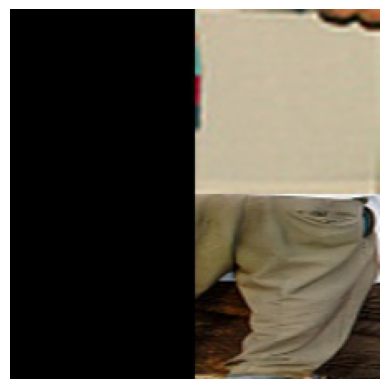

In [30]:
# print origin image
seed = 10086
np.random.seed(seed)

i=0
trainer = prepare(trainer, task_id=i)
    
learner = trainer.learner
model = learner.model
prompt = model.prompt
learner.aux.update_source(trainer.test_dataset)

learner.epoch = 0

'''sampling by aux'''
samples, labels = learner.aux.sampling(100, sort=True)     # [1000, 3, 224, 224]
samples = samples.cuda()
labels = labels.cuda()
n_samples = samples.shape[0]


img_idx = 10
print(f'label: {labels[img_idx]}')
image = unnormalize(samples[img_idx])
fig, ax = plt.subplots()
ax.imshow(image)
ax.axis('off')


# put image with maximal effect of prompt p: p(img)=loss(img; P/p) - loss(img; P); P is all prompt

In [7]:
# seed
seed = 10086
np.random.seed(seed)
torch.manual_seed(seed)

mask = 0.0
mask_mode = 'maskout'       # maskout   use
trainer = None
samples = None
labels = None
collections = {}
for i in range(3): 
    print(f'i: {i}')
    trainer = prepare(trainer, task_id=i)
    
    learner = trainer.learner
    model = learner.model
    prompt = model.prompt
    learner.epoch = 0
    learner.n_obj = i*10 + 10

    trainer.test_dataset.load_dataset(i, train=False)       # load all old and current tasks
    learner.aux.update_source(trainer.test_dataset)         # train_dataset or test_dataset
    
    # if i == 0: 
    #     continue
    
    samples, labels = learner.aux.sampling(500, sort=True)     # [500, 3, 224, 224]
    if learner.gpu:
        samples = samples.cuda()
        labels = labels.cuda()
    n_samples = samples.shape[0]
    
    # obtain unmasked objs
    with torch.no_grad():
        out = learner.model(samples, pen=False, train=False, debug_mode=False)
        logits = out
        logits = logits[:, :learner.valid_out_dim]
        # logits[:, :learner.last_valid_out_dim] = -float('inf')
        dw_cls = learner.dw_k[-1 * torch.ones(labels.size()).long()]
        unmasked_objs = learner.criterion_fn(logits, labels.long()) * dw_cls        # [100]
                
    n_layers = 12
    layers = list(range(n_layers))      # [0, 1, 2, 3, 4] 
    # layers = [0, 1, 2, 3, 4]
    # fig, axes = plt.subplots(2, len(layers), subplot_kw={'polar': True}, figsize=(3*len(layers), 3*2))

    for layer_idx in layers:
        print(f'layer_idx: {layer_idx}')

        fig, axes = plt.subplots(2, learner.n_obj, figsize=(3*learner.n_obj, 3*2))

        for obj_idx in range(learner.n_obj):
            print(f'obj_idx: {obj_idx}')
            with torch.no_grad():
                out = learner.model(samples, pen=False, train=False,
                                    hard_obj_idx=obj_idx, hard_l=layer_idx,
                                    mask=mask, mask_mode=mask_mode,
                                    # register_blk=hard_l,
                                    debug_mode=False)
                logits = out
                logits = logits[:, :learner.valid_out_dim]
                # logits[:, :learner.last_valid_out_dim] = -float('inf')
                dw_cls = learner.dw_k[-1 * torch.ones(labels.size()).long()]
                masked_objs = learner.criterion_fn(logits, labels.long()) * dw_cls        # [100]

            # find sample with maximal effect: argmax(masked_objs - unmasked_objs)
            img_idx = torch.argmax((masked_objs - unmasked_objs))       #  / (unmasked_objs + 1e-6)
            sample = samples[img_idx].cpu().numpy()
            label = labels[img_idx].item()
            label_str, [task_id, label_id] = learner.aux.source.relabel2str(label)
            ori_label = learner.aux.source.benchmark.original_classes_in_exp[task_id][label_id]
            masked_obj = masked_objs[img_idx].item()
            unmasked_obj = unmasked_objs[img_idx].item()
            print(f't{task_id}-re{label}-ori{ori_label}-{label_str}: mask{masked_obj} unmask{unmasked_obj}')

            # collect 1 sample for each objective       argmax or argmin
            collections[f'{i}_{layer_idx}_{obj_idx}'] = {'sample': sample, 'label': label, 'ori_label': ori_label, 'label_str': label_str, 'masked_obj': masked_obj, 'unmasked_obj': unmasked_obj}

            image = unnormalize(torch.from_numpy(sample))
            axes[0, obj_idx].imshow(image)
            axes[0, obj_idx].axis('off')
            axes[0, obj_idx].set_title(f'{task_id}-{label_str} {masked_obj:.2f}-{unmasked_obj:.2f}')

            # obtain attn on this image  
            out = model(torch.from_numpy(sample).unsqueeze(0).cuda(), pen=False, train=True, 
                        hard_obj_idx=obj_idx,
                        hard_l=layer_idx,
                        mask=mask, mask_mode=mask_mode,
                        register_blk=layer_idx, debug_mode=False)
            # locate attention map
            attention_map = model.feat.blocks[layer_idx].attn.attention_map.detach().cpu().numpy()
            # [bs1, head12, q197, k201]    

            # mean over all heads
            attn = np.mean(attention_map, axis=1)  # [bs1, q197, k201]

            max_attn = np.max(attn[0])

            # mean over 4 prompts
            attn = np.mean(attn[:, :, :4], axis=2)      # [bs1, q197]

            visualize_att_map(attn[0], image, ax=axes[1, obj_idx])
            axes[1, obj_idx].set_title(f'CLS{attn[0, 0]:.3f} {np.max(attn[0]):.3f}/{max_attn:.3f}')

        with open(f'{args.log_dir}/temp/collections-re_p-abs-{mask_mode}-{mask}.pkl', 'wb') as f: 
            pickle.dump(collections, f)
        # with open(f'{args.log_dir}/temp/collections.pkl', 'rb') as f: 
        #     collections = pickle.load(f)

        # save to folder
        if not os.path.exists(f'{args.log_dir}/temp/re_p-abs-{mask_mode}-{mask}-{learner.n_obj}-obj'):
            os.mkdir(f'{args.log_dir}/temp/re_p-abs-{mask_mode}-{mask}-{learner.n_obj}-obj')
        fig.savefig(f'{args.log_dir}/temp/re_p-abs-{mask_mode}-{mask}-{learner.n_obj}-obj/attn-{mask_mode}-{mask}-t{i}-l{layer_idx}.png', bbox_inches='tight', dpi=150)  # task{i}
        plt.close(fig) 


i: 0
*****************************************
Mask info: use->0.0
====================== 1 =======================
Incremental class: Old valid output dimension: 0
Incremental class: New Valid output dimension: 10
=> Load Done
layer_idx: 0
obj_idx: 0
t0-re9-ori95-('pole', 'table'): mask4.163311004638672 unmask1.6104285717010498
obj_idx: 1
t0-re9-ori95-('pole', 'table'): mask5.615945816040039 unmask1.6104285717010498
obj_idx: 2
t0-re9-ori95-('pole', 'table'): mask2.595414400100708 unmask1.6104285717010498
obj_idx: 3
t0-re9-ori95-('pole', 'table'): mask5.970249176025391 unmask1.6104285717010498
obj_idx: 4
t0-re9-ori95-('pole', 'table'): mask6.40696382522583 unmask1.6104285717010498
obj_idx: 5
t0-re9-ori95-('pole', 'table'): mask4.471348285675049 unmask1.6104285717010498
obj_idx: 6
t0-re9-ori95-('pole', 'table'): mask3.0668931007385254 unmask1.6104285717010498
obj_idx: 7
t0-re7-ori73-('helmet', 'shirt'): mask2.384140968322754 unmask1.1668936014175415
obj_idx: 8
t0-re7-ori73-('helmet', 's

# 画pt的矩阵图